In [ ]:
from analysis import rois_to_pixels
from glob import glob
from pprint import pprint
from sklearn import decomposition
from skimage.transform import downscale_local_mean
from tifffile import imwrite
from visualization import show_one_image
from visualization import show_array_images
from wfield.io import mmap_dat

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [ ]:
root_path = '/home/wrx/Data_WF/WF_WRX/'
# root_path = '/home/wrx/Data_DOM/Widefield'
mouse_id = 'Q39'
date = '20240829'
treatment = 'saline'

treatment_folder = os.path.join(root_path, mouse_id, f'{date}_{treatment}')
print(treatment_folder)

In [ ]:
# the bin_path
stim_folders = [f for f in glob(os.path.join(treatment_folder, '*')) if \
    os.path.isdir(f)]
pprint(stim_folders)
wfield_folder = glob(os.path.join(stim_folders[0], 'process', '*wfield'))[0]
print(os.path.exists(wfield_folder))
bin_path = glob(os.path.join(wfield_folder, '*.bin'))[0]
print(bin_path)

In [ ]:
# read the bin file
data = mmap_dat(bin_path)
print(data.shape)

start, end = 9000, 12000
data = data[start:end, 0, :, :]
print('Shape of data:', data.shape)
data_mean = np.mean(data, axis=0)
show_one_image(data_mean, cmap='hot')

In [ ]:
data_mean = np.mean(data, axis=0)
show_one_image(data_mean, cmap='hot', colorbar=True)

In [ ]:
reference_path = os.path.join(wfield_folder, 'reference.tif')
print(reference_path)
imwrite(reference_path, data_mean.astype(np.uint16))

The number of rois: 4
(2, 1797)


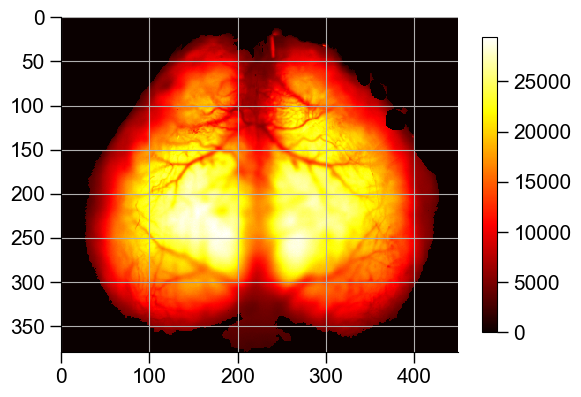

In [ ]:
mask_path = os.path.join(wfield_folder, 'mask.zip')
pixels = rois_to_pixels(mask_path, data_mean.shape)
print(pixels.shape)

data_masked = data.copy()
data_masked[:, pixels[1, :], pixels[0, :]] = 0
show_one_image(data_masked[0], cmap='hot', colorbar=True)

PCA

Shape of data_downsample: (3000, 95, 113)
Shape of _data: (3000, 10735)


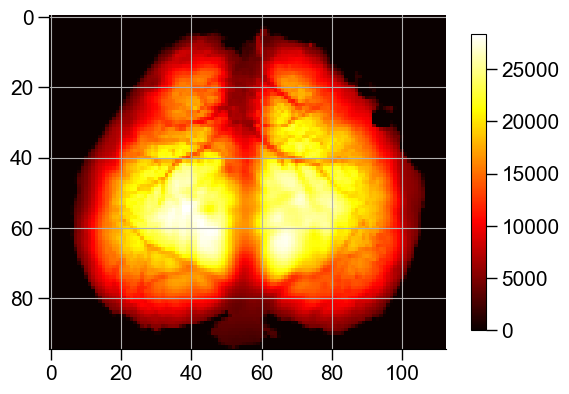

In [17]:
data_downsample = downscale_local_mean(data_masked, (1, 4, 4))
print('Shape of data_downsample:', data_downsample.shape)
_data = data_downsample.reshape(data_downsample.shape[0], -1)
print('Shape of _data:', _data.shape)
show_one_image(data_downsample[0], cmap='hot', colorbar=True)

In [18]:
n_components = 40
whiten = True
svd_solver = 'randomized'
random_state = 42
pca_estimator = decomposition.PCA(n_components=n_components, whiten=whiten,
    svd_solver=svd_solver, random_state=random_state)
# X: {array-like, sparse matrix} of shape (n_samples, n_features)
pca_estimator.fit(_data)

print(len(pca_estimator.components_))
print(pca_estimator.components_.shape)
print(pca_estimator.explained_variance_ratio_.sum())

pac_components = pca_estimator.components_
print('Shape of pac_components:', pac_components.shape)

40
(40, 10735)
0.9942729654050934
Shape of pac_components: (40, 10735)


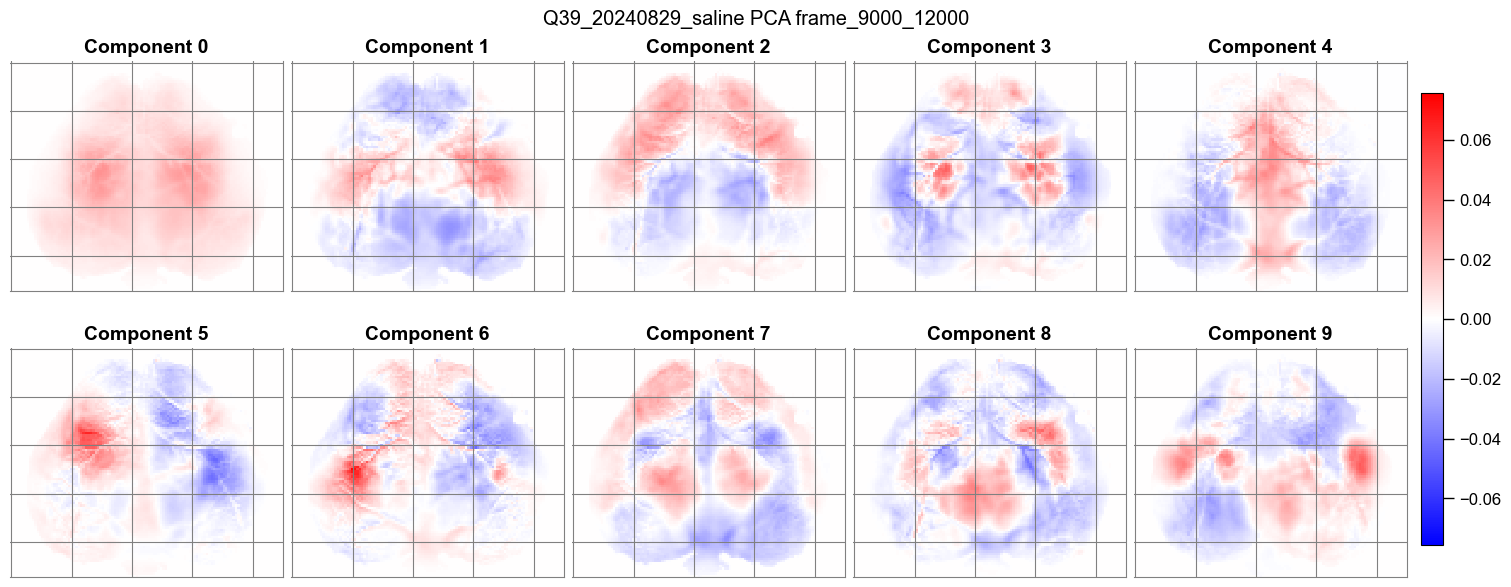

In [19]:
n_show = 10
title = f'{mouse_id}_{date}_{treatment} PCA frame_{start}_{end}'
show_array_images(pac_components[: n_show].reshape(n_show,
    data_downsample.shape[1], data_downsample.shape[2]),
    cmap='bwr', title=title)

In [20]:
data_inverse = pca_estimator.inverse_transform(pca_estimator.transform(_data))
print('Shape of data_inverse:', data_inverse.shape)

Shape of data_inverse: (3000, 10735)


In [ ]:
data_inverse_reshape = data_inverse.reshape(data_downsample.shape)
print('Shape of data_inverse_reshape:', data_inverse_reshape.shape)

FastICA

In [23]:
n_components = 10
max_iter = 1000
random_state = 42
ica_estimator = decomposition.FastICA(n_components=n_components,
    max_iter=max_iter, random_state=random_state)

# X: array-like of shape (n_samples, n_features)
ica_estimator.fit(data_inverse) # data_inverse
print(ica_estimator.components_.max(), ica_estimator.components_.min())

1.3937132025923658e-05 -9.83451733447138e-06


Shape of reshaped ICA components: (10, 95, 113)


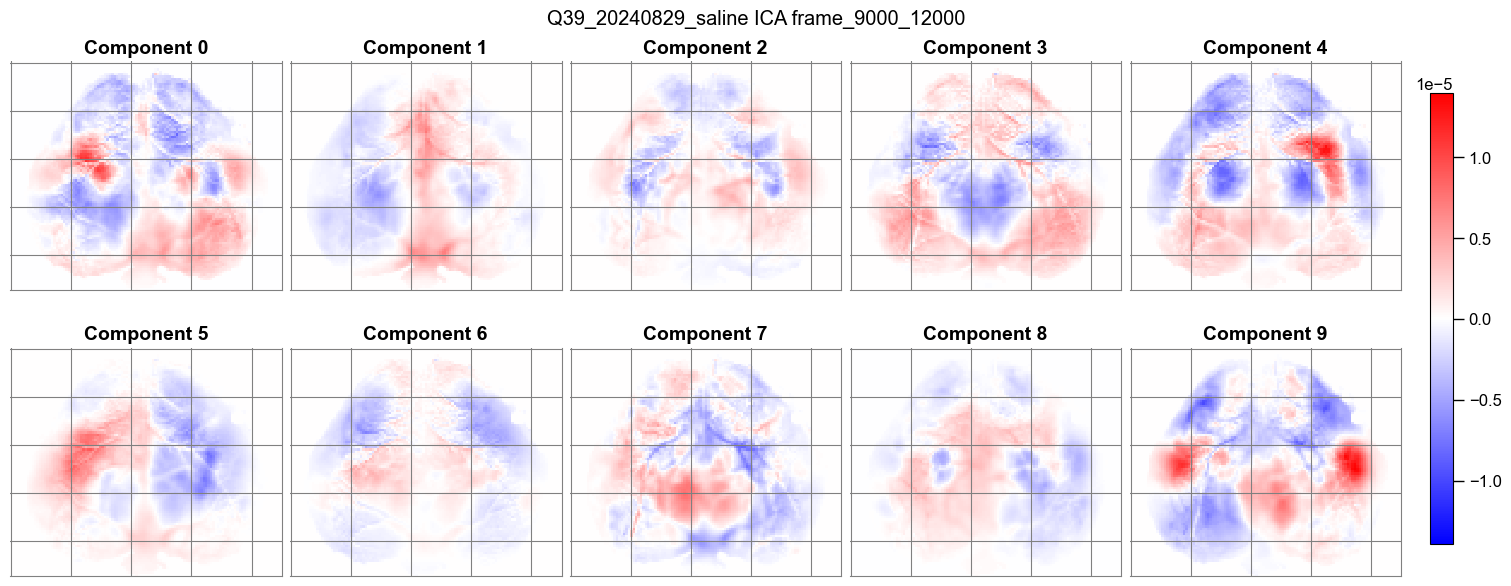

In [24]:
ica_components = ica_estimator.components_.reshape(n_components, 
    *data_downsample.shape[1:])
print('Shape of reshaped ICA components:', ica_components.shape)
title = f'{mouse_id}_{date}_{treatment} ICA frame_{start}_{end}'
show_array_images(ica_components, n_cols=5, cmap='bwr', title=title)

In [ ]:
components_masked = ica_components.copy()
components_masked[np.abs(ica_components) < 0.3 * ica_components.max()] = 0
show_array_images(components_masked, n_cols=5, cmap='bwr')

In [ ]:
components_sum = np.sum(components_masked, axis=0)
show_one_image(components_sum, cmap='bwr')

ICA using jadeR

In [ ]:
import sys
sys.path.append('./ICA')
from jadeR import jadeR

In [ ]:
data_preview = data[:500, 0, :, :]
print('Shape of data_preview:', data_preview.shape)

In [ ]:
_data = data_preview.reshape(data_preview.shape[0], -1)
print('Shape of the _data:', _data.shape)

In [ ]:
n_IC = 40
jade_ica = jadeR(_data, m=n_IC, verbose=True)

In [ ]:
print(len(jade_ica))
print(jade_ica[0].shape)

In [ ]:
jade_ica[0].max(), jade_ica[0].min()

In [ ]:
jade_ica[0]

In [ ]:
plt.hist(jade_ica[0].flatten(), bins=100)
plt.show()